<a href="https://colab.research.google.com/github/vallesda/proyecto-integrador-2024/blob/main/Avance4_Equipo21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tecnológico de Monterrey**

# **Proyecto Integrador**
## Avance 4
## Baseline
###Dra. Grettel Barceló Alonso
###EQUIPO 21
###Bernardo Mijango Flores - A01793654
###Dalia Isabel López Tapia - A01245026
###David Valles Canedo - A01191310
19 de mayo de 2024

# Importaciones, Funciones, Dependencias y Pasos Iniciales

In [1]:
!pip install --upgrade nbformat nbconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.4/257.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: mistune
    Found existing installation: mistune 0.8.4
    Uninstalling mistune-0.8.4:
      Successfully uninstalled mistune-0.8.4
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 6.5.4
    Uninstalling nbconvert-6.5.4:
      Successfully uninstalled nbconvert-6.5.4


In [2]:
# conectamos al drive de google para la lectura de los archivos csv
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns   # para un mejor despliegue de los gráficos

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score  # Importar accuracy_score desde sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

#Las siguientes librerías son los modelos que voy a entrenar y el método de validación cruzada k-fold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree  # para el grafico de arbol de decision
from IPython.display import Image

import scipy.cluster.hierarchy as sch   # requerimos el módulo referente a la agrupamiento jerárquico.
from sklearn.cluster import AgglomerativeClustering    # usaremos la técnica de agrupamiento llamada aglomerativa


In [4]:
# función para mostrar un diagrama de caja encima de un histograma
def plot_boxplot_hist(data, variable):
  f,(ax_box, ax_hist) = plt.subplots(2,
                                     sharex=True,
                                     gridspec_kw={"height_ratios":(0.50,0.85)})
  sns.boxplot(x=data[variable],ax=ax_box)
  sns.histplot(data=data, x=variable, ax=ax_hist)
  ax_box.set(xlabel="")
  plt.title(variable)
  plt.show()


In [5]:
# función para encontrar los límites de una distribución variable usando la regla de proximidad del rango intercuartil:

def find_limits(df,variable,fold):
  IQR = df[variable].quantile(0.75)-df[variable].quantile(0.25)
  lower_limit = df[variable].quantile(0.25)-(IQR * fold)
  upper_limit = df[variable].quantile(0.75)+(IQR * fold)
  return lower_limit, upper_limit

In [6]:
def get_models():

    models = list()
    names = list()

    # LR - Regresión Logística:
    models.append(LogisticRegression(solver='liblinear'))
    names.append('Logistic Regression')

    # DT - Árbol de Decisión:
    models.append(DecisionTreeClassifier())
    names.append('Decision Tree')

    # RFC - Random forest classifier
    models.append(RandomForestClassifier())
    names.append('Random Forest Classifier')

    return models, names

In [7]:
def mi_accuracy (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_accuracy = (VP + VN) / (VP + VN + FP + FN)
  return mi_accuracy

def mi_precision (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_precision = VP / (VP + FP)
  return mi_precision

def mi_recall (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_recall = VP / (VP + FN)
  return mi_recall

def mi_f1_score (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_f1_score = (2*VP) / (2*VP + FP + FN)
  return mi_f1_score

def mi_G_mean (y_real, y_pred):
  VN, FP, FN, VP = confusion_matrix(y_real, y_pred).ravel()
  mi_G_mean = np.sqrt((VP / (VP + FN))*(VN / (VN + FP)))
  return mi_G_mean

In [8]:
def plot_roc(fpr_svc, tpr_svc, roc_auc_svc):
  plt.figure()
  plt.plot(fpr_svc, tpr_svc, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_svc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

In [9]:
def calculate_print_metrics(model, y_test, y_pred):
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, pos_label='CAN')
  recall = recall_score(y_test, y_pred, pos_label='CAN')
  f1 = f1_score(y_test, y_pred, pos_label='CAN')
  confusion_matrixs = confusion_matrix(y_test, y_pred)

  print(model)
  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-Score:", f1)
  print("Confusion Matrix:\n", confusion_matrixs)

# Lectura de los datos

Se realizo una corrección en la consulta de la base de datos para obtener la edad del cliente al momento del desembolso del crédito, en el avance 1 nos dimos cuenta de este error, además se agregaron los castigos en el mismo archivo dando un total de 4,382,214 registros resultado de los 4,254,537 del archivo de pagos mas 127,677 del archivo de castigos

In [10]:
# Lectura de los archivos csv
file_path = '/content/drive/MyDrive/DataSetProyecto/GrupalTodoCorregido.csv'

label = ["IdCliente","FechaAltaCliente","CodigoGrupo","EdadCliente","Genero","EstadoCivil","Escolaridad","CapacidadPago","Localidad","CodigoSucursal","CodigoASesor","NumeroCredito","CicloCliente","FechaDesembolso","FechaVencimiento","FechaCancelacion","Plazo","PeriodoPago","EstatusCredito","MontoCredito","CuotaNumero","CuotaFechaVencimiento","CuotaFechaCancelacion","MontoCuota","MontoCapital","SaldoCapital","EstatusCuota","DiasAtraso"]

# Obtenemos el dataframe
grupal_df = pd.read_csv(file_path, names=label)

grupal_df.shape

(4382214, 28)

In [11]:
grupal_df.isnull().sum()

IdCliente                   0
FechaAltaCliente            0
CodigoGrupo                 0
EdadCliente                 0
Genero                      0
EstadoCivil                 0
Escolaridad              1243
CapacidadPago               0
Localidad                   0
CodigoSucursal              0
CodigoASesor                0
NumeroCredito               0
CicloCliente                0
FechaDesembolso             0
FechaVencimiento            0
FechaCancelacion            0
Plazo                       0
PeriodoPago                 0
EstatusCredito              0
MontoCredito                0
CuotaNumero                 0
CuotaFechaVencimiento       0
CuotaFechaCancelacion     128
MontoCuota                  0
MontoCapital                0
SaldoCapital                0
EstatusCuota                0
DiasAtraso                128
dtype: int64

Text(0.5, 1.0, 'Proporcion de datos faltantes por variable')

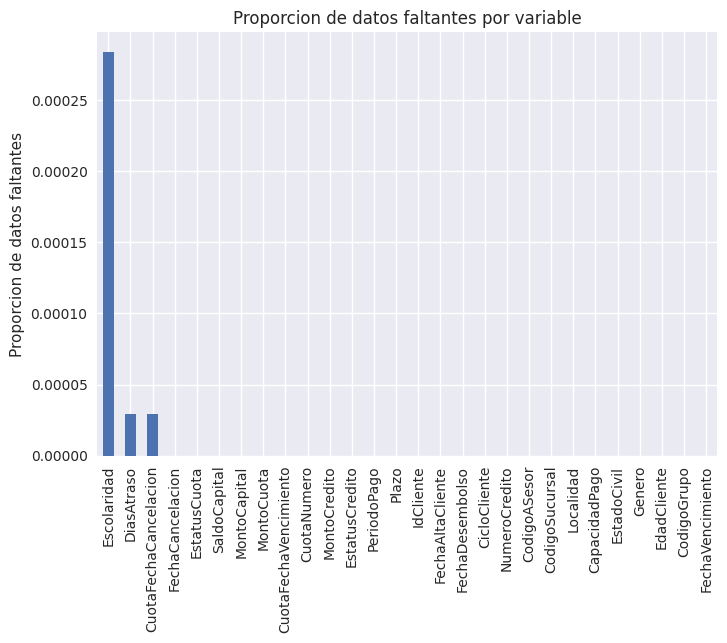

In [12]:
# visualizamos la proporcion de los datos faltantes

with plt.style.context("seaborn"):
  grupal_df.isnull().mean().sort_values(ascending=False).plot.bar(rot=90)

plt.ylabel("Proporcion de datos faltantes")
plt.title("Proporcion de datos faltantes por variable")


Al ser un procentaje menor al 0.028 % se decide eliminarlos de la muestra

In [13]:
# eliminamos los valores nulos
gpdf = grupal_df.dropna()

In [14]:
gpdf.isnull().values.any()

False

In [15]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

In [16]:
gpdf.shape

(4380844, 28)

In [17]:
# Reemplazamos los valores negativos de la variable DiasAtraso por 0 ya que son pagos anticipados
gpdf.loc[gpdf['DiasAtraso'] < 1,'DiasAtraso'] = 0


In [18]:
print(gpdf.describe(exclude=[object]))

          IdCliente   CodigoGrupo   EdadCliente   EstadoCivil  CapacidadPago  \
count  4.380844e+06  4.380844e+06  4.380844e+06  4.380844e+06   4.380844e+06   
mean   5.902005e+04  8.415457e+02  3.944503e+01  3.268472e+00   7.633413e+03   
std    3.836093e+04  5.770191e+02  1.305678e+01  1.669057e+00   3.069242e+04   
min    4.000000e+00  0.000000e+00  1.500000e+01  1.000000e+00  -6.391200e+06   
25%    2.367200e+04  3.130000e+02  2.900000e+01  2.000000e+00   2.400000e+03   
50%    5.530600e+04  8.230000e+02  3.800000e+01  3.000000e+00   6.000000e+03   
75%    9.229100e+04  1.244000e+03  4.800000e+01  5.000000e+00   1.017600e+04   
max    1.376940e+05  2.594000e+03  1.010000e+02  7.000000e+00   8.000400e+06   

          Localidad  CodigoSucursal  NumeroCredito  CicloCliente  \
count  4.380844e+06    4.380844e+06   4.380844e+06  4.380844e+06   
mean   7.607020e+03    6.142390e+00   6.143053e+09  5.265920e+00   
std    3.124029e+03    4.096959e+00   4.096748e+09  4.991101e+00   
min    

In [19]:
print(gpdf.describe(include=[object]))

               FechaAltaCliente   Genero Escolaridad CodigoASesor  \
count                   4380844  4380844     4380844      4380844   
unique                    15962        2          14          528   
top     2004-02-05 00:00:00.000        F          1A       ACORZO   
freq                       7669  4378507     1302653        98613   

                FechaDesembolso         FechaVencimiento  \
count                   4380844                  4380844   
unique                     3268                     2816   
top     2013-04-30 00:00:00.000  2019-06-04 00:00:00.000   
freq                       6944                     4869   

               FechaCancelacion   PeriodoPago EstatusCredito  \
count                   4380844       4380844        4380844   
unique                     3303             3              2   
top     2015-12-08 00:00:00.000  CATORCENA(S)            CAN   
freq                       7115       3816897        4253254   

          CuotaFechaVencimiento 

In [20]:
gpdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4380844 entries, 0 to 4382213
Data columns (total 28 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   IdCliente              int64  
 1   FechaAltaCliente       object 
 2   CodigoGrupo            int64  
 3   EdadCliente            int64  
 4   Genero                 object 
 5   EstadoCivil            int64  
 6   Escolaridad            object 
 7   CapacidadPago          float64
 8   Localidad              int64  
 9   CodigoSucursal         int64  
 10  CodigoASesor           object 
 11  NumeroCredito          int64  
 12  CicloCliente           int64  
 13  FechaDesembolso        object 
 14  FechaVencimiento       object 
 15  FechaCancelacion       object 
 16  Plazo                  int64  
 17  PeriodoPago            object 
 18  EstatusCredito         object 
 19  MontoCredito           float64
 20  CuotaNumero            int64  
 21  CuotaFechaVencimiento  object 
 22  CuotaFechaCancelacion  

### Se agregan los valores Maximos, la Media y la Mediana de la variable DiasAtraso por cliente y por credito

In [21]:
# obtenemos el Maximo Dias de Atraso y las siguientes variables numericas
gpmdadf = gpdf.groupby(['IdCliente','EdadCliente','NumeroCredito','CicloCliente','Plazo','EstadoCivil','EstatusCredito'])['DiasAtraso'].max().reset_index()

# renombramos la columna de la media
gpmdadf.rename(columns={'DiasAtraso':'DAMax'}, inplace=True)

gpmdadf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 23.2+ MB


In [22]:
# obtenemos media de los Dias de Atraso por credito
gpmeandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].mean().reset_index()

# obtenemos mediana de los Dias de Atraso por credito
gpmediandf = gpdf.groupby(['IdCliente','NumeroCredito'])['DiasAtraso'].median().reset_index()

# renombramos la columna de la media
gpmeandf.rename(columns={'DiasAtraso':'DAMean'}, inplace=True)

# renombramos la columna de la mediana
gpmediandf.rename(columns={'DiasAtraso':'DAMedian'}, inplace=True)


In [23]:
gpmeandf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMean         380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [24]:
gpmediandf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 3 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   IdCliente      380284 non-null  int64  
 1   NumeroCredito  380284 non-null  int64  
 2   DAMedian       380284 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 8.7 MB


In [25]:
print(gpmdadf[gpmdadf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito  DAMax  
1            CAN    0.0  
2            CAN    2.0  
3            CAN    2.0  
4            CAN  185.0  


In [26]:
print(gpmeandf[gpmeandf['IdCliente']==6])

   IdCliente  NumeroCredito     DAMean
1          6     1000539201   0.000000
2          6     1000619301   0.333333
3          6     1000696601   0.466667
4          6     1000835501  23.400000


In [27]:
print(gpmediandf[gpmediandf['IdCliente']==6])

   IdCliente  NumeroCredito  DAMedian
1          6     1000539201       0.0
2          6     1000619301       0.0
3          6     1000696601       0.0
4          6     1000835501       1.0


In [28]:
# agregamos la columan de la media
newdf = pd.merge(gpmdadf, gpmeandf[['IdCliente','NumeroCredito','DAMean']], on=['IdCliente','NumeroCredito'], how='left')

# agregamos la columna de la mediana
newdf = pd.merge(newdf, gpmediandf[['IdCliente','NumeroCredito','DAMedian']], on=['IdCliente','NumeroCredito'], how='left')

In [29]:
# mostramos los datos del cliente 6
print(newdf[newdf['IdCliente']==6])

   IdCliente  EdadCliente  NumeroCredito  CicloCliente  Plazo  EstadoCivil  \
1          6           34     1000539201             1     15            5   
2          6           34     1000619301             2     15            5   
3          6           35     1000696601             3     15            5   
4          6           36     1000835501             4     25            5   

  EstatusCredito  DAMax     DAMean  DAMedian  
1            CAN    0.0   0.000000       0.0  
2            CAN    2.0   0.333333       0.0  
3            CAN    2.0   0.466667       0.0  
4            CAN  185.0  23.400000       1.0  


In [30]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380284 entries, 0 to 380283
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   IdCliente       380284 non-null  int64  
 1   EdadCliente     380284 non-null  int64  
 2   NumeroCredito   380284 non-null  int64  
 3   CicloCliente    380284 non-null  int64  
 4   Plazo           380284 non-null  int64  
 5   EstadoCivil     380284 non-null  int64  
 6   EstatusCredito  380284 non-null  object 
 7   DAMax           380284 non-null  float64
 8   DAMean          380284 non-null  float64
 9   DAMedian        380284 non-null  float64
dtypes: float64(3), int64(6), object(1)
memory usage: 29.0+ MB


In [31]:
newdf.head()

,IdCliente,EdadCliente,NumeroCredito,CicloCliente,Plazo,EstadoCivil,EstatusCredito,DAMax,DAMean,DAMedian
0,4,65,1000353601,1,15,4,CAN,2.0,0.266667,0.0
1,6,34,1000539201,1,15,5,CAN,0.0,0.000000,0.0
2,6,34,1000619301,2,15,5,CAN,2.0,0.333333,0.0
3,6,35,1000696601,3,15,5,CAN,2.0,0.466667,0.0
4,6,36,1000835501,4,25,5,CAN,185.0,23.400000,1.0


#Baseline

# Avance 4


In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import time

Preprocesamiento de variables

In [33]:
# Definir la variable objetivo y las características
newdf['EstatusCredito'] = newdf['EstatusCredito'].map({'CAI': 0, 'CAN': 1})
X = newdf.drop('EstatusCredito', axis=1)  # Todas las columnas excepto 'EstatusCredito' son características independientes
y = newdf['EstatusCredito']  # 'EstatusCredito' es la variable objetivo

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Verificar las dimensiones de los conjuntos de entrenamiento y prueba
print("Dimensiones del conjunto de entrenamiento (X):", X_train.shape)
print("Dimensiones del conjunto de prueba (X):", X_test.shape)
print("Dimensiones del conjunto de entrenamiento (y):", y_train.shape)
print("Dimensiones del conjunto de prueba (y):", y_test.shape)

Dimensiones del conjunto de entrenamiento (X): (304227, 9)
Dimensiones del conjunto de prueba (X): (76057, 9)
Dimensiones del conjunto de entrenamiento (y): (304227,)
Dimensiones del conjunto de prueba (y): (76057,)


In [49]:
# Transformaciones que se aplicarán a las variables numéricas usando la clase Pipeline de sklearn:

# Variables numéricas:
num_pipe = Pipeline([
    ('log_transform', FunctionTransformer(np.log1p)),  # Transformación logarítmica
    ('min_max_scaler', MinMaxScaler())  # Escalado Min-Max
])
num_pipe_nombres = ['DAMax', 'DAMean', 'EdadCliente']

# Variables categóricas:
cat_pipe = Pipeline([
    ('one_hot_encoding', OneHotEncoder())  # Codificación One-Hot
])
cat_pipe_nombres = ['CicloCliente', 'Plazo', 'EstadoCivil']


# Variables sin transformar:
no_trans_pipe = 'passthrough'
no_trans_nombres = ['IdCliente', 'NumeroCredito']

# Conjuntemos las transformaciones de todo tipo de variable y en dado caso
# deja inalteradas aquellas que hayas decidido no transformar:

columnasTransformer = ColumnTransformer([
    ('num', num_pipe, num_pipe_nombres),  # Variables numéricas
    ('cat', cat_pipe, cat_pipe_nombres),  # Variables categóricas
    ('notrans', no_trans_pipe, no_trans_nombres)  # Variables sin tranformar
])


In [63]:
# Como se va a utilizar Validación-Cruzada, concatena los conjuntos de entrenamiento y validación
# en uno nuevo aumentado que llamaremos trainval para utilizar como entrenamiento:

# Concatenar los conjuntos de entrenamiento y validación
Xtrainval = pd.concat([X_train, X_test], ignore_index=True)
ytrainval = pd.concat([y_train, y_test], ignore_index=True)

# Mostrar las dimensiones del nuevo conjunto trainval
print(Xtrainval.shape, ytrainval.shape)

(380284, 9) (380284,)


Construir al menos 6 modelos diferentes, utilizando algoritmos variados.

In [35]:
def mis_modelos():
  modelos, nombres = list(), list()

  # Regresión Logística:
  modelos.append(LogisticRegression(max_iter=10000, random_state=15, solver='lbfgs'))
  nombres.append('LR')

  # k-Vecinos más Cercanos:
  modelos.append(KNeighborsClassifier(n_neighbors=10, weights='distance'))
  nombres.append('kNN')

  # Árbol de decisiones:
  modelos.append(DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=15))
  nombres.append('DTree')

  # XGBoosting:
  modelos.append(XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=15))
  nombres.append('XGBoost')

  # Red neuronal de Perceptrón Multicapa:
  modelos.append(MLPClassifier(max_iter=10000, hidden_layer_sizes=(100,50), activation='relu', random_state=15))
  nombres.append('MLP')

  # Máquina de Vectores de Soporte:
  # Corrio por 4 horas, se comento por eficiencia
  # modelos.append(SVC(kernel='rbf', C=1.0, random_state=15))
  # nombres.append('SVM')

  return modelos, nombres

Comparar el rendimiento de los modelos obtenidos.

In [36]:
#Entrenemos cada uno de los modelos y desplegamos la métricas de Train y Val.

modelos, nombres = mis_modelos()
resultados = list()

for i in range(len(modelos)):

  # Definimos nuestro pipeline con las transformaciones y los modelos:
  #
  #
  # TODO: ('ct',columnasTransformer),
  pipeline = Pipeline(steps=[('m',modelos[i])])

  # Aplicaremos validación-cruzada:
  micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

  # Definimos las métricas que desamos recuperar:
  mismetricas = {'accuracy','precision','recall','f1','roc_auc'}

  # Iniciamos timer
  start_time = time.time()

  # Llevamos a cabo el entrenamiento:
  scores = cross_validate(pipeline,
                          Xtrainval,
                          ytrainval,
                          scoring=mismetricas,
                          cv=micv,
                          return_train_score=True,
                          )

  # Detenemos el temporizador
  end_time = time.time()

  # Guardemos el resultado de cada modelopara análisis posteriores.
  resultados.append(scores)

  # Desplegamos los valores de las métricas para verificar si no hay
  # subentrenamiento o sobreentrenamiento:
  print('>> %s' % nombres[i])
  print('\t Training time: %.3f seconds' % (end_time - start_time))
  for j,k in enumerate(list(scores.keys())):
    if j>1:
      print('\t %s %.3f (%.3f)' % (k, np.mean(scores[k]),np.std(scores[k])))

>> LR
	 Training time: 19.819 seconds
	 test_accuracy 0.968 (0.000)
	 train_accuracy 0.968 (0.000)
	 test_roc_auc 0.381 (0.006)
	 train_roc_auc 0.381 (0.002)
	 test_f1 0.984 (0.000)
	 train_f1 0.984 (0.000)
	 test_recall 1.000 (0.000)
	 train_recall 1.000 (0.000)
	 test_precision 0.968 (0.000)
	 train_precision 0.968 (0.000)
>> kNN
	 Training time: 124.535 seconds
	 test_accuracy 0.984 (0.000)
	 train_accuracy 1.000 (0.000)
	 test_roc_auc 0.868 (0.005)
	 train_roc_auc 1.000 (0.000)
	 test_f1 0.992 (0.000)
	 train_f1 1.000 (0.000)
	 test_recall 0.997 (0.000)
	 train_recall 1.000 (0.000)
	 test_precision 0.987 (0.000)
	 train_precision 1.000 (0.000)
>> DTree
	 Training time: 20.429 seconds
	 test_accuracy 0.996 (0.000)
	 train_accuracy 0.996 (0.000)
	 test_roc_auc 0.993 (0.001)
	 train_roc_auc 0.995 (0.000)
	 test_f1 0.998 (0.000)
	 train_f1 0.998 (0.000)
	 test_recall 0.998 (0.000)
	 train_recall 0.998 (0.000)
	 test_precision 0.998 (0.000)
	 train_precision 0.998 (0.000)
>> XGBoost
	 T

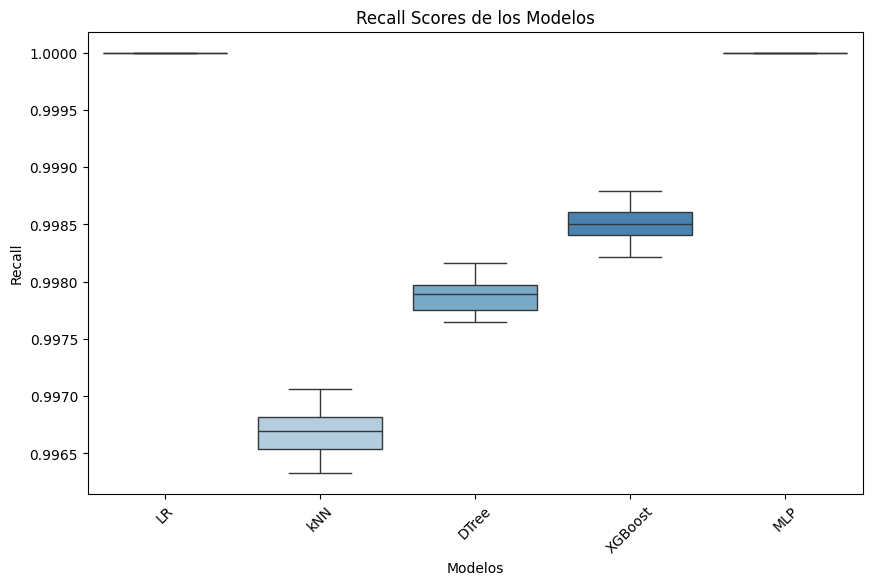

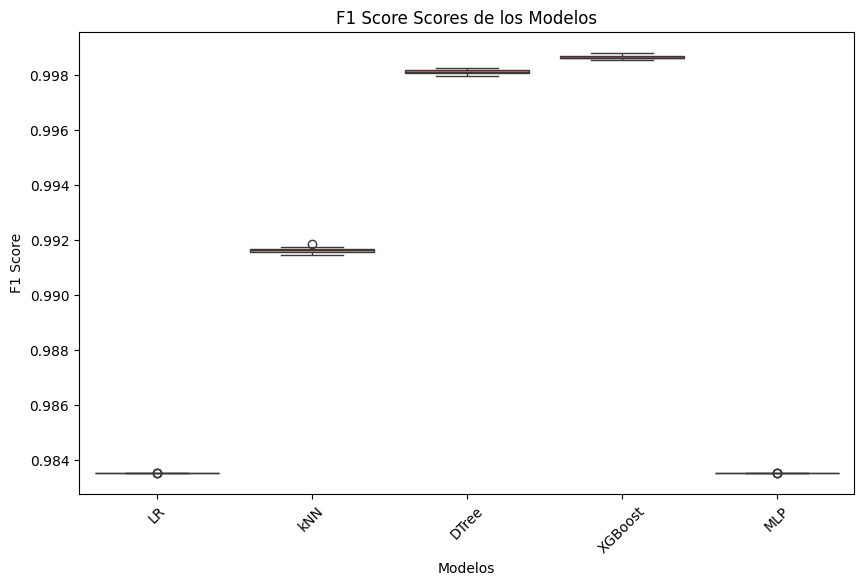

In [37]:
def plot_metric_scores(metric_scores, metric_name, color_palette):
    df = pd.DataFrame(metric_scores)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, palette=color_palette)
    plt.title(f'{metric_name} Scores de los Modelos')
    plt.ylabel(metric_name)
    plt.xlabel('Modelos')
    plt.xticks(rotation=45)
    plt.show()

# Recolectar recall y plotear
recall_scores = {nombres[i]: resultados[i]['test_recall'] for i in range(len(modelos))}
plot_metric_scores(recall_scores, 'Recall', 'Blues')

# Recolectar F1-score y plotear
f1_scores = {nombres[i]: resultados[i]['test_f1'] for i in range(len(modelos))}
plot_metric_scores(f1_scores, 'F1 Score', 'Reds')


Seleccionar los dos modelos que proporcionen el mejor rendimiento.

In [65]:
#SMOTE para clases no balanceadas
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline

In [45]:
def mis_modelos2():
    modelos, nombres = list(), list()

    # Regresión Logística:
    modelos.append(LogisticRegression(max_iter=10000, random_state=15, solver='lbfgs'))
    nombres.append('LR')

    # Árbol de decisiones:
    modelos.append(DecisionTreeClassifier(max_depth=5, criterion='entropy', random_state=15))
    nombres.append('DTree')
    return modelos, nombres

Ajustar los dos mejores modelos.

En nuestro caso tenemos las clases 0 (no pago) y 1 (pago), es importante considerar cómo el desbalance afecta el rendimiento del modelo y qué técnicas de manejo de desbalance pueden ser útiles. Creemos que nuestro modelo puede predecir efectivamente la clase mayoritaria pero no contamos con suficientes evidencias para demostrar la clasificacion de de la clase no pago. Por esta razon nuestro equipo decidio usar SMOTE para crear muestras sinteticas y corregir los problemas de desbalanceo.

In [68]:
modelos, nombres = mis_modelos2()
resultados = list()
sampling_strategy = 0.75

for i in range(len(modelos)):
    # Definimos nuestro pipeline con las transformaciones y los modelos:
    pipeline = imPipeline(steps=[('sampling', SMOTE(sampling_strategy=sampling_strategy)),
                               #('ct',columnasTransformer),
                               ('m', modelos[i])])


    # Aplicaremos validación-cruzada:
    micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)

    # Definimos las métricas que deseamos recuperar:
    mismetricas = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}

    # Iniciamos timer
    start_time = time.time()

    # Llevamos a cabo el entrenamiento:
    scores = cross_validate(pipeline,
                            Xtrainval,
                            ytrainval,
                            scoring=mismetricas,
                            cv=micv,
                            return_train_score=True)

    # Detenemos el temporizador
    end_time = time.time()

    # Guardamos el resultado de cada modelo para análisis posteriores.
    resultados.append(scores)

    # Desplegamos los valores de las métricas para verificar si no hay
    # subentrenamiento o sobreentrenamiento:
    print('>> %s' % nombres[i])
    print('\t Training time: %.3f seconds' % (end_time - start_time))
    for j, k in enumerate(list(scores.keys())):
        if j > 1:
            print('\t %s %.3f (%.3f)' % (k, np.mean(scores[k]), np.std(scores[k])))

>> Logistic Regression
	 Training time: 26.104 seconds
	 test_accuracy 0.968 (0.000)
	 train_accuracy 0.968 (0.000)
	 test_roc_auc 0.381 (0.006)
	 train_roc_auc 0.381 (0.001)
	 test_f1 0.984 (0.000)
	 train_f1 0.984 (0.000)
	 test_recall 1.000 (0.000)
	 train_recall 1.000 (0.000)
	 test_precision 0.968 (0.000)
	 train_precision 0.968 (0.000)
>> Decision Tree
	 Training time: 85.589 seconds
	 test_accuracy 0.994 (0.000)
	 train_accuracy 1.000 (0.000)
	 test_roc_auc 0.975 (0.002)
	 train_roc_auc 1.000 (0.000)
	 test_f1 0.997 (0.000)
	 train_f1 1.000 (0.000)
	 test_recall 0.995 (0.000)
	 train_recall 1.000 (0.000)
	 test_precision 0.999 (0.000)
	 train_precision 1.000 (0.000)


In [ ]:
# Con dicho mejor modelo y utilizando la técnica de validación cruzada, busca
# los mejores hiperparámetros de dicho modelo
from sklearn.model_selection import GridSearchCV

# Definimos el Pipeline con SMOTE, transformaciones y Regresión Logística
pipeline = imPipeline([
    ('balanceo', SMOTE(sampling_strategy=0.75)),
    #('transformaciones', columnasTransformer),
    ('regresion_logistica', LogisticRegression(max_iter=10000, random_state=15))
])

# Definimos el espacio de búsqueda para GridSearchCV
parametros_grid = {
    'regresion_logistica__penalty': ['l2'],
    'regresion_logistica__C': [0.001, 0.01, 0.1, 1, 10],
    'regresion_logistica__solver': ['liblinear', 'saga', 'lbfgs']
}

# Utilizamos GridSearchCV para buscar hiperparámetros óptimos
busqueda_grid = GridSearchCV(estimator=pipeline, param_grid=parametros_grid, scoring='f1', cv=5)
busqueda_grid.fit(Xtrainval, ytrainval)

print("Mejores hiperparámetros:")
print(busqueda_grid.best_params_)

# Seleccionamos el mejor modelo encontrado por GridSearchCV
mejor_modelo = busqueda_grid.best_estimator_

# Aplicamos Validación-Cruzada y mostramos los resultados
micv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3)
mismetricas = {'accuracy', 'precision', 'recall', 'f1', 'roc_auc'}
resultados_validacion = cross_validate(mejor_modelo, Xtrainval, ytrainval, scoring=mismetricas, cv=micv, return_train_score=True)

print('Resultados de validación cruzada:')
for metrica in mismetricas:
    print(f"{metrica.capitalize()} promedio:", np.mean(resultados_validacion[f"test_{metrica}"]),
          f"({np.std(resultados_validacion[f'test_{metrica}']):.3f})")


Elegir el modelo individual final.

In [ ]:
#### TODO

In [ ]:
# el mejor modelo y los mejores hiperparámetros encontrados en el ejercicio anterior,
# utiliza ahora (por primera vez en la actividad) el conjunto de prueba (test set) para:

y_pred_test = mejor_modelo.predict(Xtest)

print("Métricas en el conjunto de prueba:")
print(classification_report(ytest, y_pred_test))


In [ ]:
# b.	Obtener la matriz de confusión.

from sklearn.metrics import confusion_matrix

# Realizar predicciones en el conjunto de prueba
y_pred_test = mejor_modelo.predict(Xtest)

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(ytest, y_pred_test)

# Mostrar la matriz de confusión
print("Matriz de confusión en el conjunto de prueba:")
print(conf_matrix)
